## The goal: to have more analysis and understanding on the 2000 + schools that are within a mile of a superfund site. 

## I want to see the median income for the schools near superfund sites. Let's do this in R. 

In [ ]:
from dotenv import load_dotenv
load_dotenv() 

True

In [ ]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%%R 
census_api_key(Sys.getenv("CENSUS_API_KEY"))

To install your API key for use in future sessions, run this function with `install = TRUE`.


In [ ]:
%%R 

Sys.getenv("CENSUS_API_KEY")


[1] ""


In [ ]:
%%R 

library(readr)

df <- read_csv("..src/data/processed/csv/merged-schools-superfunds.csv")


df


Rows: 6485 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): NAME, Site_Name, STATE, CITY
dbl (5): distance_to_site_miles, ZIP, CNTY, LAT, LON

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 6,485 × 9
   NAME    Site_Name distance_to_site_miles   ZIP STATE CITY   CNTY   LAT    LON
   <chr>   <chr>                      <dbl> <dbl> <chr> <chr> <dbl> <dbl>  <dbl>
 1 LONGFE… Fruit Av…                 0.0457 87102 NM    ALBU… 35001  35.1 -107. 
 2 Insigh… Commence…                 0.0508 98409 WA    Taco… 53053  47.2 -122. 
 3 Basin … Basin Mi…                 0.0593 59631 MT    Basin 30043  46.3 -112. 
 4 Van Cl… East Tro…                 0.0663 45373 OH    Troy  39109  40.0  -84.2
 5 North … North Be…                 0.0682 28012 NC    Belm… 37071  35.3  -81.1
 6 INES M… Cabo Roj…                 0.0697   6

## Convert CNTY data to a character. 

In [73]:
%%R

library(dplyr)
library(stringr)

df <- df %>%
  mutate(
    CNTY = str_pad(as.character(CNTY), width = 5, pad = "0")
  )


## Get median income data from census. 

In [74]:
%%R
county_income <- get_acs(
  geography = "county",
  variables = c(med_inc = "B19013_001"),
  year = 2021,
  survey = "acs5",
  geometry = FALSE
) %>%
  select(GEOID, med_inc = estimate)

# Check first few rows
head(county_income)


# A tibble: 6 × 2
  GEOID med_inc
  <chr>   <dbl>
1 01001   62660
2 01003   64346
3 01005   36422
4 01007   54277
5 01009   52830
6 01011   29063


Getting data from the 2017-2021 5-year ACS


## Join county-level median income to the schools&superfund sites dataset. 

In [75]:
%%R

schools_with_income <- df %>%
  left_join(county_income, by = c("CNTY" = "GEOID"))

# Quick check for missing values
pct_missing <- mean(is.na(schools_with_income$med_inc)) * 100
print(paste0("Percent of schools missing income: ", round(pct_missing, 1), "%"))

# View first rows
head(schools_with_income)

[1] "Percent of schools missing income: 1%"
# A tibble: 6 × 10
  NAME     Site_Name distance_to_site_miles   ZIP STATE CITY  CNTY    LAT    LON
  <chr>    <chr>                      <dbl> <dbl> <chr> <chr> <chr> <dbl>  <dbl>
1 LONGFEL… Fruit Av…                 0.0457 87102 NM    ALBU… 35001  35.1 -107. 
2 Insight… Commence…                 0.0508 98409 WA    Taco… 53053  47.2 -122. 
3 Basin S… Basin Mi…                 0.0593 59631 MT    Basin 30043  46.3 -112. 
4 Van Cle… East Tro…                 0.0663 45373 OH    Troy  39109  40.0  -84.2
5 North B… North Be…                 0.0682 28012 NC    Belm… 37071  35.3  -81.1
6 INES MA… Cabo Roj…                 0.0697   623 PR    CABO… 72023  18.1  -67.1
# ℹ 1 more variable: med_inc <dbl>


## "low-income county" as counties in the bottom 25th percentile of median income within each state

In [76]:
%%R
state_thresholds <- county_income %>%
  mutate(state_fips = substr(GEOID, 1, 2)) %>%  
  group_by(state_fips) %>%
  summarise(
    p25 = quantile(med_inc, 0.25, na.rm = TRUE),
    p50 = quantile(med_inc, 0.50, na.rm = TRUE),
    state_median = median(med_inc, na.rm = TRUE),
    n_counties = n()
  )

print(state_thresholds)

schools_with_income <- schools_with_income %>%
  mutate(state_fips = substr(CNTY, 1, 2)) %>%
  left_join(state_thresholds, by = "state_fips") %>%
  mutate(
    low_income_county = ifelse(med_inc < p25, 1, 0),
    low_income_county = ifelse(is.na(med_inc), NA, low_income_county)
  )

state_summary <- schools_with_income %>%
  group_by(state_fips) %>%
  summarise(
    total_schools = n(),
    schools_in_low_income = sum(low_income_county == 1, na.rm = TRUE),
    pct_in_low_income = mean(low_income_county == 1, na.rm = TRUE) * 100
  ) %>%
  arrange(desc(pct_in_low_income))

print(state_summary)

# A tibble: 52 × 5
   state_fips    p25    p50 state_median n_counties
   <chr>       <dbl>  <dbl>        <dbl>      <int>
 1 01         43214. 46186        46186          67
 2 02         62425  71890.       71890.         30
 3 04         47932  55077        55077          15
 4 05         41076. 45318        45318          75
 5 06         58833. 70037        70037          58
 6 08         49818. 61672.       61672.         64
 7 09         78041. 82558.       82558.          8
 8 10         66300. 68886        68886           3
 9 11         93547  93547        93547           1
10 12         46958. 56786        56786          67
# ℹ 42 more rows
# ℹ Use `print(n = ...)` to see more rows
# A tibble: 52 × 4
   state_fips total_schools schools_in_low_income pct_in_low_income
   <chr>              <int>                 <int>             <dbl>
 1 44                    27                    15              55.6
 2 16                     7                     3              42.9
 3 34  

## Now, let's print out how many schools are considered low-income county schools. 

In [77]:
%%R

summary_stats <- schools_with_income %>%
  summarise(
    total = n(),
    low_income = sum(low_income_county == 1, na.rm = TRUE),
    pct = mean(low_income_county == 1, na.rm = TRUE) * 100,
    missing = sum(is.na(low_income_county))
  )

cat(sprintf("Total Schools:              %s\n", 
            format(summary_stats$total, big.mark = ",")))
cat(sprintf("Low-Income County Schools:  %s\n", 
            format(summary_stats$low_income, big.mark = ",")))
cat(sprintf("Percentage Low-Income:      %.1f%%\n", 
            summary_stats$pct))
cat(sprintf("Missing Data:               %s\n", 
            format(summary_stats$missing, big.mark = ",")))


Total Schools:              6,485
Low-Income County Schools:  580
Percentage Low-Income:      9.0%
Missing Data:               67


## Let's visualize this finding using a waffle chart 

In [78]:
%%R
schools_per_square <- 50

waffle_data_scaled <- round(waffle_data / schools_per_square)

waffle_data_scaled

Low-Income County Schools             Other Schools              Missing Data 
                       12                       117                         1 


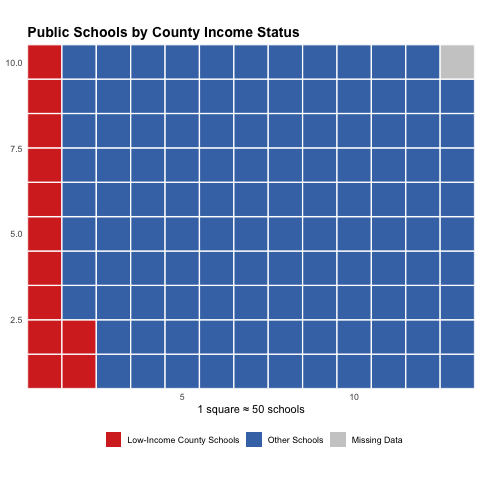

In [84]:
%%R
waffle(
  waffle_data_scaled,
  rows = 10,
  size = 0.6,
  colors = c(
    "Low-Income County Schools" = "#d73027",
    "Other Schools" = "#4575b4",
    "Missing Data" = "#cccccc"
  ), 
  title = "Public Schools by County Income Status",
  xlab = paste("1 square ≈", schools_per_square, "schools")
) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    legend.position = "bottom"
  )

In [83]:
%%R 
ggsave(
  filename = "../assets/svg/schools_waffle.svg",
  plot = last_plot(),
  device = "svg",
  width = 7,
  height = 5,
  units = "in"
)

## Wonderful waffle chart. But, I want to make a circular one to somewhat match my beeswarm chart. 

#### I will rely on this code found here https://medium.com/@ralitza.soultanova/how-to-make-a-circular-waffle-chart-in-r-with-ggplot-a-step-by-step-guide-9118c019c236

In [90]:
%%R 
require(ggplot2) 
require(ggimage)

Loading required package: ggimage
Error: package or namespace load failed for ‘ggimage’ in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 namespace ‘ggplot2’ 3.5.2 is already loaded, but >= 4.0.0 is required
In addition: Warning message:
package ‘ggimage’ was built under R version 4.4.3 


In [ ]:
%%R 
ggplot(df, aes(x, y, color=migrant))+
  geom_point()

## Beeswarm chart showing the distribution of school distances (in miles) from the nearest Superfund site


In [43]:
%%R 

library(readr)

df <- read_csv("../all_datasets/schools_and_superfund/schools_and_superfund_1.csv")

df


Rows: 6485 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): NAME, Site_Name, STATE, CITY
dbl (3): distance_to_site_miles, ZIP, CNTY

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 6,485 × 7
   NAME                 Site_Name distance_to_site_miles   ZIP STATE CITY   CNTY
   <chr>                <chr>                      <dbl> <dbl> <chr> <chr> <dbl>
 1 LONGFELLOW ELEMENTA… Fruit Av…                 0.0457 87102 NM    ALBU… 35001
 2 Insight School of W… Commence…                 0.0508 98409 WA    Taco… 53053
 3 Basin School         Basin Mi…                 0.0593 59631 MT    Basin 30043
 4 Van Cleve Elementar… East Tro…                 0.0663 45373 OH    Troy  39109
 5 North Belmont Eleme… North Be…                 0.0682 28012 NC    Belm… 37071
 6 INES MARIA MENDOZA … Cabo Roj…                 0.0697 

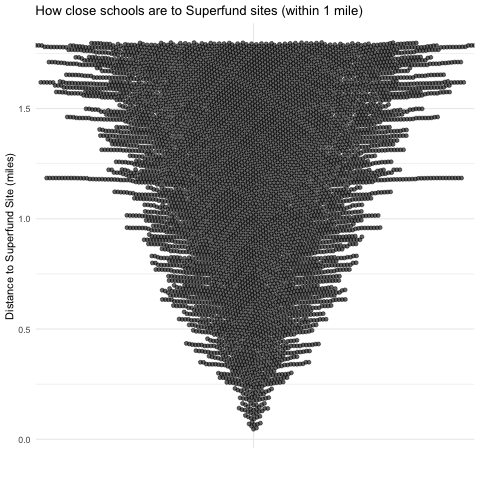

In [44]:
%%R 
library(ggplot2)
library(ggbeeswarm)
library(tidycensus)
library(tidyverse)
ggplot(df, aes(
  x = "",
  y = distance_to_site_miles
)) +
  geom_beeswarm(
    size = 1.5,
    alpha = 0.6
  ) +
  theme_minimal() +
  labs(
    title = "How close schools are to Superfund sites (within 1 mile)",
    x = "",
    y = "Distance to Superfund Site (miles)"
  )

In [45]:
%%R 
ggsave(
  filename = "../assets/svg/schools_beeswarm.svg",
  plot = last_plot(),
  device = "svg",
  width = 7,
  height = 5,
  units = "in"
)

## Future goals (when time permits)
### Look at racial makeup of these schools. See what percentage of students attending these schools rely on free lunch program to get a better understanding of which students are most impacted.  

# END